# MSSE 277B: Machine Learning Algorithms 

## Homework assignment #5: Statistical Models 

### Student Name: Charis Liao 

#### Assigned Feb. 23 and Due Mar. 7 

# 1. Baye's Theorem

A chemical test is designed to indirectly determine whether the individual has a
genetic marker predisposing him/her to having kidney disease. The chemical test has the following
characteristics: the probability that a randomly chosen person who has the marker (M) will test positive (i.e.
"marker present") is: P[+|M] = 0.95; the probability that a randomly chosen person who does not have the
marker will test negative is: P[-|not M] = 0.95; the proportion of people who have the marker is: P[M] =
0.01.

**(a) Define the following quantities: P[-|M]; P[+|not M]; P[not M].**    

$P[-|M] = 0.05$: The probability that a randomly chosen person who has the marker (M) will test negative.  

$P[+|not M] = 0.05$: The probability that a randomly chosen person who does not have the marker (M) will test positive. 

$P[not M] = 0.99$: The proportion of people who do not have the marker. 

**(b) You have had a chemical test and have tested positive; should you be alarmed? To answer this,
find what is the chance that a randomly selected person who tests positive for the marker actually has the
marker by using Baye’s Theorem. What feature of the given data accounts for the result?**     

$$ P[M|+] = \frac{P[+|M]P[M]}{P[+|M]P[M] + P[+|not M]P[not M]} =$$   
$$\frac{0.95 \times 0.01}{(0.95 \times 0.01) + (0.05 \times 0.99)} = 0.161 $$ 

No, you should not be alarmed because the probability of you actually having the marker given you've received a positive test is 0.161 which is relatively low. 

**(c) Suppose that frequency of marker was higher by a factor of 10, i.e. P[M] = 0.10. What is the
chance that a randomly selected individual from this group who test positive actually has the marker?**    

$$ P[M|+] = \frac{P[+|M]P[M]}{P[+|M]P[M] + P[+|not M]P[not M]} =$$   
$$\frac{0.95 \times 0.01}{(0.95 \times 0.01) + (0.05 \times 0.99)} = 0.6786 $$ 

In [3]:
0.95*0.1 / (0.95*0.1 + 0.05*0.9)

0.6785714285714285

The chance that a randomly selected individual from this group who test positive actually has the marker is 0.68 or 68%. 

# 2. Gaussian Naïve Bayes     
In a previous homework we clustered 178 wines into 3 cultivars by solving
the minimization of a cost function simulated annealing. We will do this again, but this time solving it with
Naïve Bayes. To do this we will classify the wines by assigning them to the cultivar with the largest
P(cultivar | X), and to find this we must first define a labelled data set of P(wine attribute x | cultivar)
pairings to learn the relationship where x is one of the attributes, and do this for all attributes.

**(a) How should we represent P(wine attribute x | cultivar) ? Fill in the code for gaussian() function and
give a reason that you choose this functional form. Given a wine that belongs to cultivar 1, what is the
chance of it having an Alcohol % of 13 according to the probability distribution function?**

In [60]:
import numpy as np 
import pandas as pd
import math 
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [39]:
class NaiveBayesClassifier():
    def __init__(self):
        self.type_indices={}    # store the indices of wines that belong to each cultivar as a boolean array of length 178
        self.type_stats={}      # store the mean and std of each cultivar
        self.ndata = 0
        self.trained=False
    
    @staticmethod
    def gaussian(x,mean,std):
        exponent = -((x - mean)**2 / (2 * std**2))
        return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(exponent)
    
    @staticmethod
    def calculate_statistics(x_values):
        # Returns a list with length of input features. Each element is a tuple, with the input feature's average and standard deviation
        n_feats=x_values.shape[1]
        return [(np.average(x_values[:,n]),np.std(x_values[:,n])) for n in range(n_feats)]
    
    @staticmethod
    def calculate_prob(x_input,stats):
        """Calculate the probability that the input features belong to a specific class(P(X|C)), defined by the statistics of features in that class
        x_input: np.array shape(nfeatures)
        stats: list of tuple [(mean1,std1),(means2,std2),...]
        """ 
        init_prob = 1 
        for i in range(len(x_input)):
            mean, std = stats[i]
            init_prob *= NaiveBayesClassifier.gaussian(x_input[i], mean, std)
        return init_prob
    
    def fit(self,xs,ys):
        # Train the classifier by calculating the statistics of different features in each class
        self.ndata = len(ys)
        for y in set(ys):
            type_filter= (ys==y)
            self.type_indices[y]=type_filter
            self.type_stats[y]=self.calculate_statistics(xs[type_filter])
        self.trained=True
            
    def predict(self,xs):
        # Do the prediction by outputing the class that has highest probability
        if len(xs.shape)>1:
            print("Only accepts one sample at a time!")
        if self.trained:
            guess=None
            max_prob=0
            # P(C|X) = P(X|C)*P(C) / sum_i(P(X|C_i)*P(C_i)) (deniminator for normalization only, can be ignored)
            for y_type in self.type_stats:
                prior = sum(self.type_indices[y_type]) / self.ndata
                prob= self.calculate_prob(xs, self.type_stats[y_type]) * prior
                if prob>max_prob:
                    max_prob=prob
                    guess=y_type
            return guess
        else:
            print("Please train the classifier first!")

In [40]:
def calculate_accuracy(model,xs,ys):
    y_pred=np.zeros_like(ys)
    for idx,x in enumerate(xs):
        y_pred[idx]=model.predict(x)
    return np.sum(ys==y_pred)/len(ys)

The reason why gaussian is chosen is that it is the mathematical representation of the normal distribution, which is one of the most widely used probability distributions in statistics and data analysis. It has a bell-shaped curve and has mean and standard deviation as parameters, which make it useful for modeling many real-world phenomena. The Gaussian function is also mathematically tractable and has a well-defined shape, making it easy to work with in calculations and visualizations.

In [41]:
# import wine dataset 
df=pd.read_csv('./wines.csv') 
# display(df)

In [59]:
# create an instance of the classifier
clf = NaiveBayesClassifier() 
# train the classifier on the dataset
clf.fit(df.iloc[:,0:-2].values, df.iloc[:,-1].values)

# calculate the probability that a wine from cultivar 1 has Alcohol % = 13
stats = clf.type_stats[1]  # get the statistics for cultivar 1

prob = clf.gaussian(13, stats[0][0], stats[0][1])  # calculate the probability using the Gaussian function

print("The chance of a wine from cultivar 1 having Alcohol % of 13 is:", prob)


The chance of a wine from cultivar 1 having Alcohol % of 13 is: 0.23236757865410362


**(b) Using your normalized chemical descriptor data from HW#2, divide your data into 3-fold training
and testing groups, i.e. using 2/3** 

In [50]:
# normalized chemical descriptor
df_norm = (df.iloc[:,0:-2] - df.iloc[:,0:-2].mean()) / df.iloc[:,0:-2].std()
df_norm

,Alcohol %,Malic Acid,Ash,Alkalinity,Mg,Phenols,Flavanoids,Phenols.1,Proantho-cyanins,Color intensity,Hue,OD280 315,Proline
0,1.514341,-0.560668,0.231400,-1.166303,1.908522,0.806722,1.031908,-0.657708,1.221438,0.251009,0.361158,1.842721,1.010159
1,0.294868,0.227053,1.835226,0.450674,1.278379,0.806722,0.661485,0.226158,0.400275,-0.318377,0.361158,0.448336,-0.037767
2,2.253415,-0.623328,-0.716315,-1.645408,-0.191954,0.806722,0.951817,-0.577356,0.679820,0.061213,0.536158,0.335659,0.946649
3,1.378844,-0.766550,-0.169557,-0.806975,-0.331985,-0.151973,0.401188,-0.818411,-0.036514,-0.025057,0.929908,0.293405,1.692900
4,0.923081,-0.542765,0.158499,-1.046527,-0.752080,0.487157,0.731565,-0.577356,0.382804,0.233755,0.842408,0.406082,1.819921
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,0.491955,2.026281,1.798775,1.648436,0.858284,-0.503494,-1.070491,-0.738059,-0.840205,1.484679,-1.257591,-0.974218,-0.371199
174,0.331822,1.739837,-0.388260,0.151234,1.418411,-1.126646,-1.340800,0.547563,-0.420888,2.217979,-1.607590,-1.481267,0.279786
175,0.208643,0.227053,0.012696,0.151234,1.418411,-1.030776,-1.350811,1.351077,-0.228701,1.829761,-1.563840,-1.396759,0.295664
176,1.391162,1.578712,1.361368,1.498716,-0.261969,-0.391646,-1.270720,1.592131,-0.420888,1.786626,-1.520090,-1.424928,-0.593486


In [57]:
# divide the data into 3-fold training and testing groups
# use 2/3 training and 1/3 testing for the three divisions
kf = KFold(n_splits=3,shuffle=True)
xs = df_norm.iloc[:,:].values 
ys = df.iloc[:,-1].values
for train_index, test_index in kf.split(xs):
    x_train, x_test = xs[train_index], xs[test_index]
    y_train, y_test = ys[train_index], ys[test_index]

    # train the classifier
    gnb = NaiveBayesClassifier()
    gnb.fit(x_train,y_train)

    print(f'Accuracy: {calculate_accuracy(gnb,x_test,y_test)}')

Accuracy: 0.9833333333333333
Accuracy: 1.0
Accuracy: 0.9661016949152542


This performance is better than the previous one with an average accuracy above 95%. 

# 3. Softmax and Cross Entropy Loss.

Work on the same wine dataset. Now we use another approach
to do the classification. Implement a neural network model using PyTorch with no hidden layer (This is
equivalent to a linear regression plus activation function). Use softmax activation function in the last layer
and use cross entropy loss as your loss function.

**(a) Pass the data through the network once without backpropagation and print out the output. Observe
the difference between with and without the softmax activation layer. What does softmax do?**

In [67]:
# Convert the features and labels to PyTorch tensors
features = torch.tensor(df_norm.iloc[:,:].values, dtype=torch.float32)
labels = torch.tensor(df.iloc[:,-1].values, dtype=torch.int64)

# Define the model
model = nn.Sequential(
    nn.Linear(features.shape[1], len(np.unique(labels)))
#     nn.identity()
)

# Pass the data through the network once without backpropagation
outputs = model(features)

# Print out the output
print(outputs)

tensor([[ 1.2842e+00,  4.4496e-01, -6.1235e-01],
        [ 3.9544e-01,  4.9609e-01, -3.8322e-01],
        [ 1.1597e+00,  4.4352e-01, -3.3465e-01],
        [ 3.2252e-01,  2.0005e-01,  1.1345e-01],
        [ 6.5048e-01,  3.1566e-01,  2.7726e-01],
        [ 6.0775e-01,  3.1100e-01, -3.6272e-01],
        [ 1.4105e+00,  3.9178e-01, -6.0870e-01],
        [ 5.3006e-01,  2.5589e-01,  2.5212e-01],
        [ 6.4879e-01,  7.7252e-01,  8.0664e-02],
        [ 7.5103e-02, -2.7768e-01,  4.7783e-01],
        [ 9.2738e-01,  3.9420e-01,  8.6092e-02],
        [ 5.6992e-02,  2.5956e-01, -3.9037e-02],
        [ 6.9960e-01,  1.8454e-01, -6.8461e-01],
        [ 1.8242e-01, -7.3868e-02,  1.1511e-01],
        [ 1.7620e+00,  3.8266e-01, -5.9698e-01],
        [ 1.1067e+00, -7.9319e-02,  1.6791e-01],
        [ 8.2152e-01,  4.3073e-01,  3.1767e-02],
        [ 8.9470e-01,  6.4870e-01,  5.7756e-02],
        [ 1.7622e+00,  2.6806e-01, -2.1963e-01],
        [ 1.6217e+00, -9.2042e-02, -2.9555e-01],
        [-1.0329e+00

In [70]:
# Pass the data through the network once without backpropagation and without softmax activation
model_with_softmax = nn.Sequential(
    nn.Linear(features.shape[1], len(np.unique(labels))),
    nn.Softmax(dim=1)
)
outputs_with_softmax = model_with_softmax(features)
print(outputs_with_softmax)

tensor([[0.3138, 0.1741, 0.5121],
        [0.2444, 0.2509, 0.5047],
        [0.3072, 0.2180, 0.4747],
        [0.2992, 0.2659, 0.4349],
        [0.3448, 0.2535, 0.4017],
        [0.3274, 0.2352, 0.4374],
        [0.3210, 0.2426, 0.4364],
        [0.3049, 0.3037, 0.3914],
        [0.2541, 0.3020, 0.4439],
        [0.3640, 0.3240, 0.3120],
        [0.3266, 0.2097, 0.4637],
        [0.2105, 0.4878, 0.3017],
        [0.2308, 0.2340, 0.5352],
        [0.2837, 0.3086, 0.4076],
        [0.4471, 0.1804, 0.3726],
        [0.4497, 0.2753, 0.2750],
        [0.3469, 0.2081, 0.4449],
        [0.2858, 0.1857, 0.5285],
        [0.4526, 0.2860, 0.2615],
        [0.5115, 0.1987, 0.2897],
        [0.1236, 0.6250, 0.2514],
        [0.2782, 0.4990, 0.2229],
        [0.3666, 0.3879, 0.2455],
        [0.2731, 0.2486, 0.4783],
        [0.2596, 0.3437, 0.3967],
        [0.1454, 0.5499, 0.3047],
        [0.2851, 0.1395, 0.5754],
        [0.1763, 0.4127, 0.4110],
        [0.2585, 0.4327, 0.3088],
        [0.209

A softmax activation funciton takes a vector of real numbers as input and normalizes it into a probability distribution that sums up to one. 

**(b) Divide your data into 3-fold training and testing groups, within each fold further divide your
training data into 80% training and 20% validation, choose the model for the epoch with lowest validation
error. Report error in terms of success rate of classification. How well is the prediction?**

In [121]:
class Wine(nn.Module):
    def __init__(self):
        super(Wine, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(13, 3),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        output = self.layers(x)
#         output += 1 # shift output range from 0-2 to 1-3
        return output

In [150]:
def train_and_val(model,train_X,train_y,epochs,draw_curve=True):
    """
    Parameters
    --------------
    model: a PyTorch model
    train_X: np.array shape(ndata,nfeatures)
    train_y: np.array shape(ndata)
    epochs: int
    draw_curve: bool
    """
    ### Define your loss function, optimizer. Convert data to torch tensor ###
    
    # Define loss function and optimizer
    loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_y = train_y - 1
    
    # Convert the data to PyTorch tensors
    Xs = torch.tensor(train_X).float()
    ys = torch.tensor(train_y).long()
    
    # Kfolds 
    kf = KFold(n_splits=3,shuffle=True)
    for train_index, test_index in kf.split(Xs):
        train_X=Xs[train_index]
        train_y=ys[train_index]
        test_X=Xs[test_index]
        test_y=ys[test_index]
    
    ### Split training examples further into training and validation ###
    train_X,val_X,train_y,val_y=train_test_split(train_X,train_y, test_size = 0.20)
    
    
    
#     val_X = torch.tensor(val_X).float()
#     val_y = torch.tensor(val_y).long()

    
    
    val_array=[]
    lowest_val_loss = np.inf
    
    for i in range(epochs):
        ### Compute the loss and do backpropagation ###
    
        optimizer.zero_grad()
        train_out = model(train_X)
        train_loss = loss(train_out, train_y)
        train_loss.backward()
        optimizer.step()
        
        ### compute validation loss and keep track of the lowest val loss ###
        

        # compute validation loss
        val_out = model(val_X) 
        val_loss = loss(val_out, val_y)
        
        
         # append val loss to val_array
        val_array.append(val_loss.item())

        # keep track of the lowest val loss
        if val_loss < lowest_val_loss:
            lowest_val_loss = val_loss
            torch.save(model.state_dict(), 'model.pt')
  
     # The final number of epochs is when the minimum error in validation set occurs    
   
    final_epochs=np.argmin(val_array)+1
    print("Number of epochs with lowest validation:",final_epochs)
    ### Recover the model weight ###
    model.load_state_dict(torch.load('model.pt'))
    model.eval()

    ### Plot the validation loss curve ###

    if draw_curve:
        plt.figure()
        plt.plot(np.arange(len(val_array))+1,val_array,label='Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

Number of epochs with lowest validation: 1000


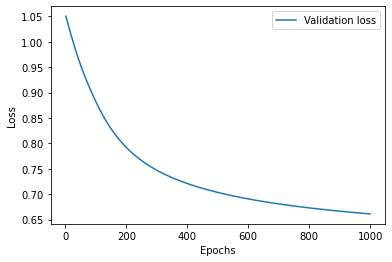

In [151]:
wine_sample = Wine()
train_and_val(wine_sample, df_norm.iloc[:,:].values, df.iloc[:,-1].values, 1000)
